In [1]:
import sys
sys.path.append('../src')

from KBSA import *

In [2]:
def generate_rv(theta):  
    u2 = random.uniform(0,1)
    u1 = random.uniform(0,1)
    L = -theta[0] * math.log(1-u2)    
    Z = -theta[1] * math.log(1-u1)+L
    return (Z, L)

theta = np.array([0.2, 0.3])
d = len(theta)
phi, psi = 0.5, 0.75

vL_true = -theta[0]*math.log(1-phi)
co_true = -theta[1]*math.log(1-psi)+vL_true
dvL_true = [-math.log(1-phi), 0]
dco_true = [-math.log(1-phi), -math.log(1-psi)]

In [3]:
N = 1e5
init_v = 1
cst, cst_h1, cst_h2, cst_c = 3,0.2,0.2,1
set_v, set_co, bound_D = [-np.inf,np.inf],[-np.inf,np.inf],np.inf

# 1) one round of the algorithm implementation

In [4]:
with np.errstate(invalid='raise'):
    try:
        co, v, Dv, Dco = sensitivity(N, psi, phi, d, theta, generate_rv, init_v,
                                    cst, cst_h1, cst_h2, cst_c,
                                    set_v, set_co, bound_D)
        print('-'*40)
        print('Estimate')
        print('VaR:', round(v[-1], 3))
        print('DVaR:', [round(Dv[-1][j], 3) for j in range(d)])
        print('CoVaR:', round(co[-1],3))
        print('DCoVaR:', [round(Dco[-1][j], 3) for j in range(d)])
        
        print('-'*40)
        print('True Value')
        print('VaR:', round(vL_true, 3))
        print('DVaR:', [round(dvL_true[j], 3) for j in range(d)])
        print('CoVaR:', round(co_true,3))
        print('DCoVaR:', [round(dco_true[j], 3) for j in range(d)])
        print('-'*40)
    except (FloatingPointError, ZeroDivisionError):
        print('Error: Division by Zero')

----------------------------------------
Estimate
VaR: 0.141
DVaR: [0.707, -0.002]
CoVaR: 0.554
DCoVaR: [0.703, 1.371]
----------------------------------------
True Value
VaR: 0.139
DVaR: [0.693, 0]
CoVaR: 0.555
DCoVaR: [0.693, 1.386]
----------------------------------------


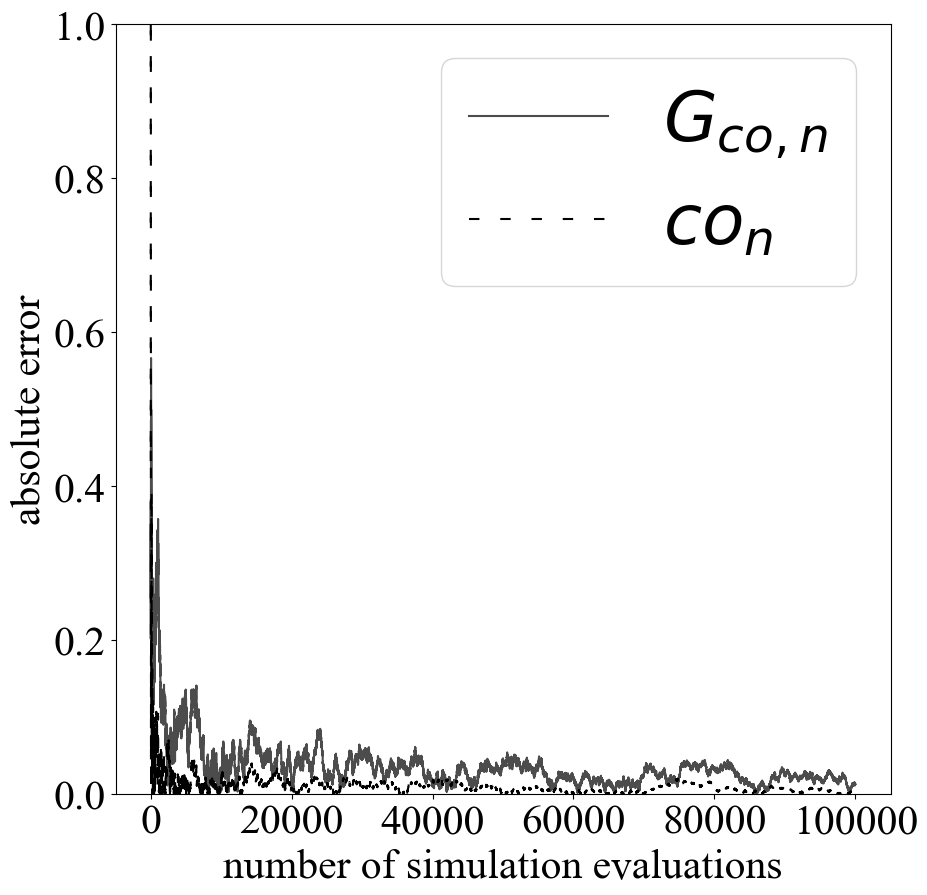

In [5]:
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

error = [np.linalg.norm(Dco[i]-dco_true)/d**.5 for i in range(len(Dco))]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))

error = [abs(co_-co_true) for co_ in co]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = (0,(5,10)))

plt.ylim(0,1)
plt.legend(fontsize=50)
plt.ylabel('absolute error')
plt.xlabel('number of simulation evaluations')
plt.show()

# 2) 100 independent replications

### implementation & save results (We have already generated and saved results in the 'results/' directory. Please skip this part and proceed to 'descriptive statistics'.)

In [ ]:
cst=1
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, theta, generate_rv, init_v,
                            cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D)
with open('../results/toy1.pkl', 'wb') as file: 
    joblib.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

In [ ]:
cst=3
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, theta, generate_rv, init_v,
                            cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D)
with open('../results/toy3.pkl', 'wb') as file: 
    pickle.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

In [ ]:
cst=5
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, theta, generate_rv, init_v,
                            cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D)
with open('../results/toy5.pkl', 'wb') as file: 
    pickle.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

### descriptive statistics

In [10]:
# with open('../results/toy1.pkl', 'rb') as f:
with open('../results/toy3.pkl', 'rb') as f:
# with open('../results/toy5.pkl', 'rb') as f:
    co_lst, v_lst, Dv_lst, Dco_lst = pickle.load(f)

In [11]:
mean_lst_co = np.mean(co_lst, axis=0)
mean_lst_Dco = np.mean(Dco_lst, axis=0)

bias_lst_co = [m-co_true for m in mean_lst_co]
bias_lst_Dco = [m-dco_true for m in mean_lst_Dco]

In [13]:
AE_lst_co = [[abs(i-co_true) for i in co_lst[j]] for j in range(len(co_lst))]
MAE_lst_co = np.mean(AE_lst_co, axis=0)

AE_lst_Dco = [[np.linalg.norm(i-dco_true) for i in Dco_lst[j]] for j in range(len(Dco_lst))]
MAE_lst_Dco = np.mean(AE_lst_Dco, axis=0)

In [14]:
SE_lst_co = [[abs(i-co_true)**2 for i in co_lst[j]] for j in range(len(co_lst))]
RMSE_lst_co = np.mean(SE_lst_co, axis=0)**.5

SE_lst_Dco = [[np.linalg.norm(i-dco_true)**2 for i in Dco_lst[j]] for j in range(len(Dco_lst))]
RMSE_lst_Dco = np.mean(SE_lst_Dco, axis=0)**.5

In [17]:
print('CoVaR estimation')
for k in [1e2,1e3,1e4,1e5]:
    k=int(k)
    print('-'*5,k,'-'*5)
    print('relative error: ',round(MAE_lst_co[k]/np.linalg.norm(co_true)*100,2),'%')
    print('MAE: ',round(MAE_lst_co[k],2))
    print('bias:', round(bias_lst_co[k],4))
    print('RMSE: ',round(RMSE_lst_co[k],2))

CoVaR estimation
----- 100 -----
relative error:  17.71 %
MAE:  0.1
bias: 0.0215
RMSE:  0.12
----- 1000 -----
relative error:  7.2 %
MAE:  0.04
bias: -0.009
RMSE:  0.05
----- 10000 -----
relative error:  2.51 %
MAE:  0.01
bias: -0.0018
RMSE:  0.02
----- 100000 -----
relative error:  0.87 %
MAE:  0.0
bias: -0.0009
RMSE:  0.01


In [18]:
print('CoVaR gradient estimation')
for k in [1e2,1e3,1e4,1e5]:
    k=int(k)
    print('-'*5,k,'-'*5)
    print('relative error: ',round(MAE_lst_Dco[k]/np.linalg.norm(dco_true)*100,2),'%')
    print('MAE: ',round(MAE_lst_Dco[k],2))
    print('bias:', [round(i,4) for i in bias_lst_Dco[k]])
    print('RMSE: ',round(RMSE_lst_Dco[k],2))

CoVaR gradient estimation
----- 100 -----
relative error:  31.39 %
MAE:  0.49
bias: [-0.039, -0.4317]
RMSE:  0.52
----- 1000 -----
relative error:  16.29 %
MAE:  0.25
bias: [-0.0314, -0.243]
RMSE:  0.27
----- 10000 -----
relative error:  4.2 %
MAE:  0.07
bias: [-0.0111, -0.0359]
RMSE:  0.07
----- 100000 -----
relative error:  2.41 %
MAE:  0.04
bias: [0.0012, -0.0018]
RMSE:  0.04


### data visualization

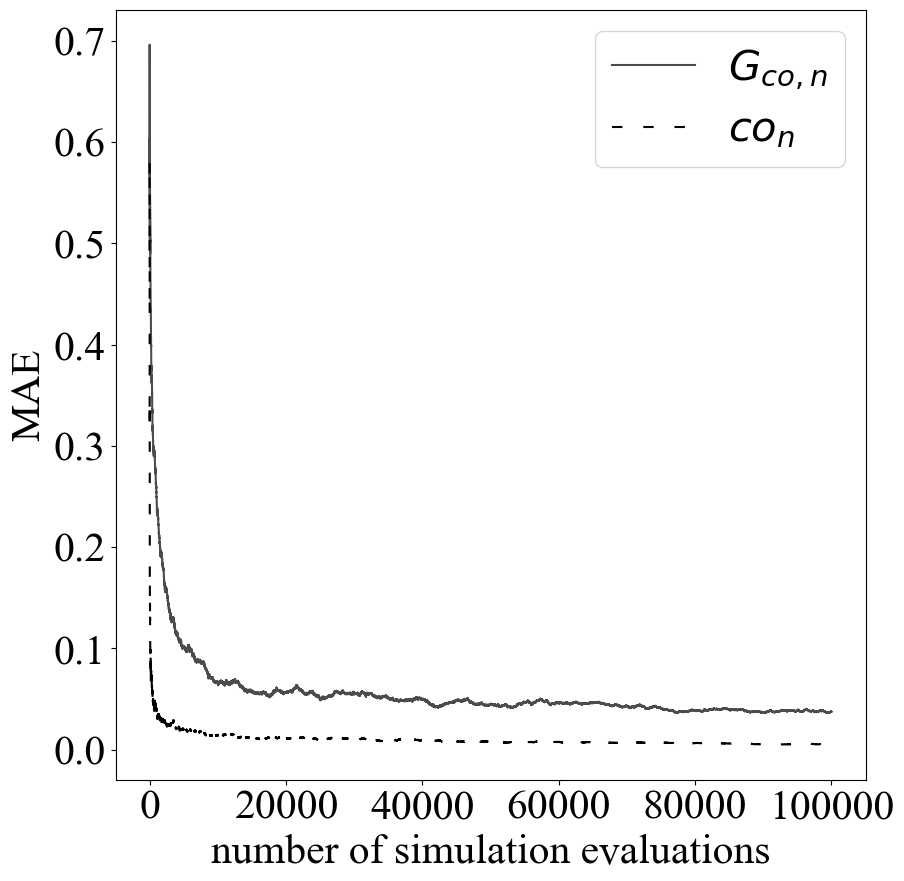

In [19]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
plt.rcParams['font.family'] = ['Times New Roman']
style=itertools.cycle(["-",(0,(1,5)),(0,(5,10))])
plt.rc('font', size=30)

error = MAE_lst_Dco
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))

# error = MAE_lst_Dco/d**.5
# plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$ (scaled)', 
#          alpha=.7,color='k', linestyle = next(style))

error = MAE_lst_co
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = (0,(5,10)))

plt.ylabel('MAE')
plt.xlabel('number of simulation evaluations')

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.show()

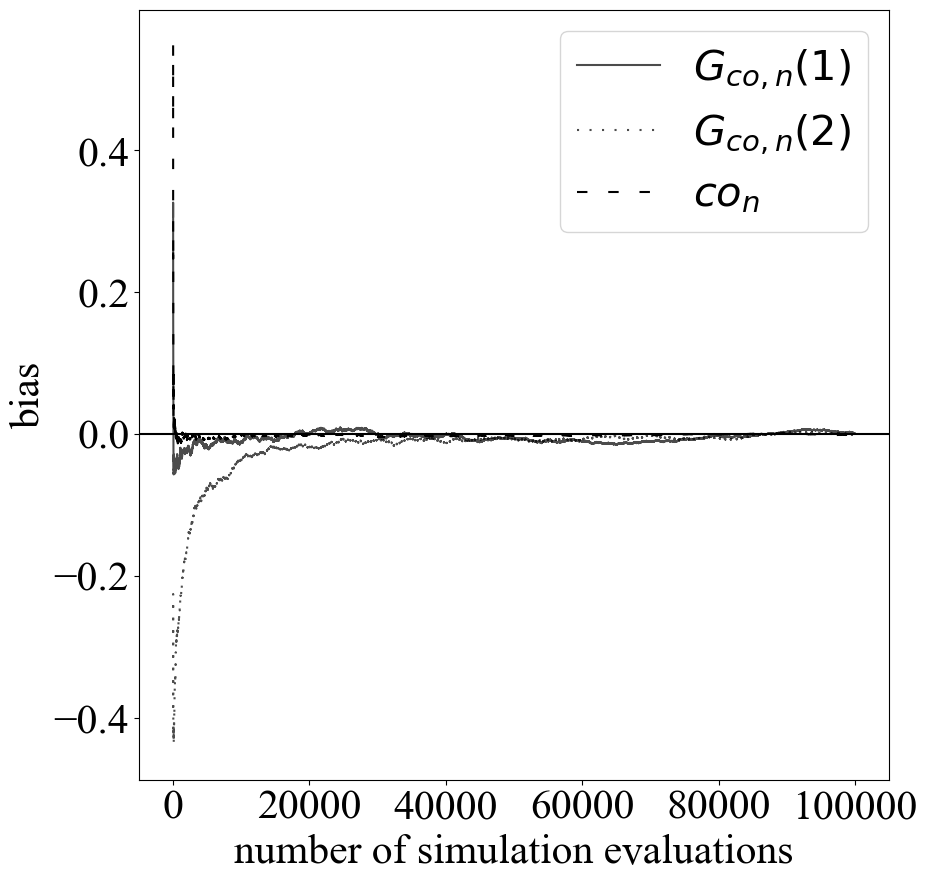

In [21]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
plt.rcParams['font.family'] = ['Times New Roman']
style=itertools.cycle(["-",(0,(1,5)),(0,(5,10))])
plt.rc('font', size=30)

error = [i[0] for i in bias_lst_Dco]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}(1)$', 
         alpha=.7,color='k', linestyle = next(style))

error = [i[1] for i in bias_lst_Dco]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}(2)$', 
         alpha=.7,color='k', linestyle = next(style))

error = bias_lst_co
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = (0,(5,10)))

plt.axhline(0, color = 'k', alpha = 1, linestyle = '-')
plt.ylabel('bias')
plt.xlabel('number of simulation evaluations')
plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.show()

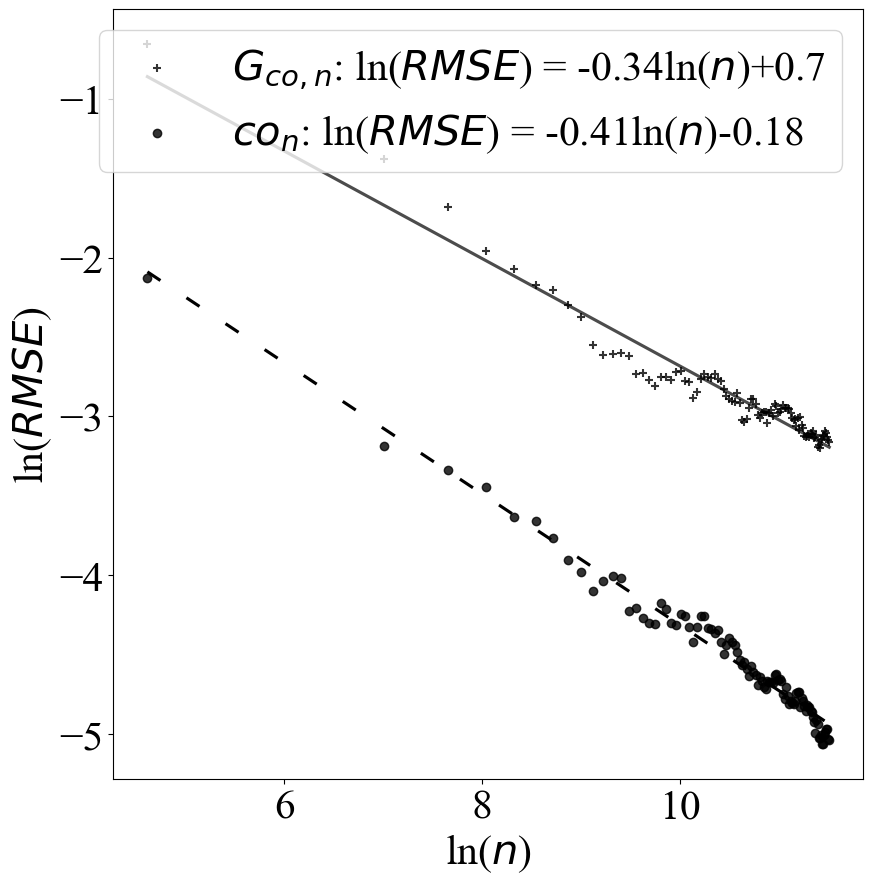

In [25]:
starts = int(1e2)
N=1e5
logn = [math.log(n+1) for n in range(int(1e2), int(N+1))][::int(1e3)]

plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['font.family'] = ['Times New Roman']
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

y=[math.log(rmse) for rmse in RMSE_lst_Dco][starts:int(N+1):int(1e3)]
slope, intercept, r, p, sterr = scipy.stats.linregress(x=logn, y=y)
sns.regplot(x=logn, y=y ,ci = None, 
            label =  r'$G_{co,n}$: '+'ln($RMSE$) = '+str(round(slope,2))+'ln($n$)+'+str(round(intercept,2)),
            color='k', marker = '+', line_kws=dict(alpha = .7, color="k", linestyle = next(style)))

y=[math.log(rmse) for rmse in RMSE_lst_co][starts:int(N+1):int(1e3)]
slope, intercept, r, p, sterr = scipy.stats.linregress(x=logn, y=y)
sns.regplot(x=logn, y=y, ci = None,
           label = r'$co_n$: '+'ln($RMSE$) = '+str(round(slope,2))+'ln($n$)'+str(round(intercept,2)),
           color='k', marker = 'o', line_kws=dict(color="k", linestyle = next(style)))

plt.ylabel('ln($RMSE$)')
plt.xlabel('ln($n$)')

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)
plt.show() 